# Human Bone Marrow from Oetjen et al.

Here we analyse sample P from [Oetjen at al.](https://insight.jci.org/articles/view/124928) (from a healthy donor) (v2 chemistry) (Cell Ranger 2.0.0).
Dataset on GEO: [GSM3396176](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396176)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Oet_BM_P_2.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [5]:
## Load previously processed dataset
adata = sc.read_h5ad(results_file)
adata.obs.index.names = ['barcode']

In [7]:
# Set up data loading
file_base = '../Munich/datasets/human/BoneMarrow_Oetjen/GSE120221_RAW/GSM3396176_'
data_file_end = 'matrix_P.mtx.gz'
barcode_file_end = 'barcodes_P.tsv.gz'
gene_file_end = 'genes_P.tsv.gz'

In [8]:
# Data set load & annotation
#Parse Filenames
data_file = file_base+data_file_end
barcode_file = file_base+barcode_file_end
gene_file = file_base+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... writing an h5ad cache file to speedup reading next time


In [9]:
adata

AnnData object with n_obs × n_vars = 3383 × 33694 
    var: 'gene_id'

In [10]:
adata.var.head()

gene_id
gene_symbol                  
RP11-34P13.3  ENSG00000243485
FAM138A       ENSG00000237613
OR4F5         ENSG00000186092
RP11-34P13.7  ENSG00000238009
RP11-34P13.8  ENSG00000239945

In [11]:
adata.var_names_make_unique()

In [12]:
# Checking the total size of the data set
adata.shape

(3383, 33694)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [13]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [14]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


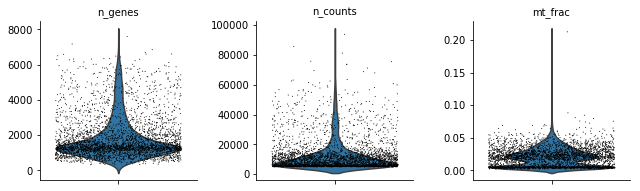

In [15]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

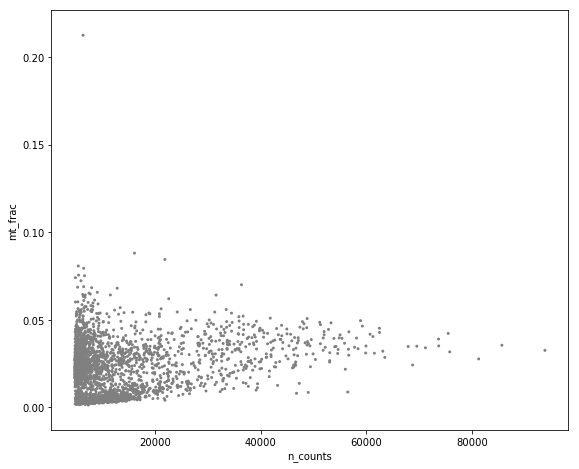

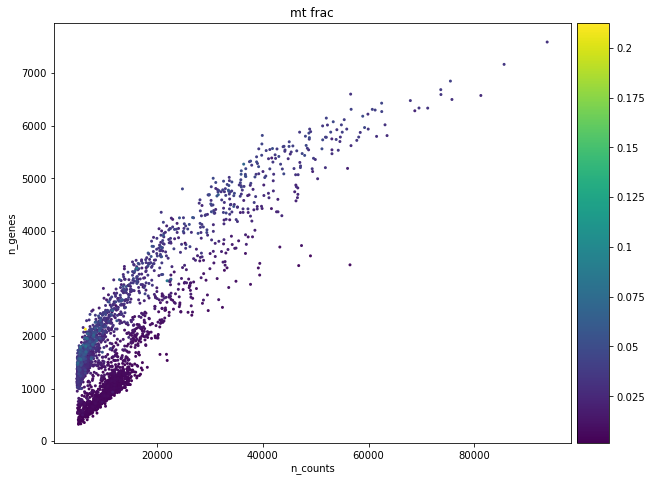

In [16]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

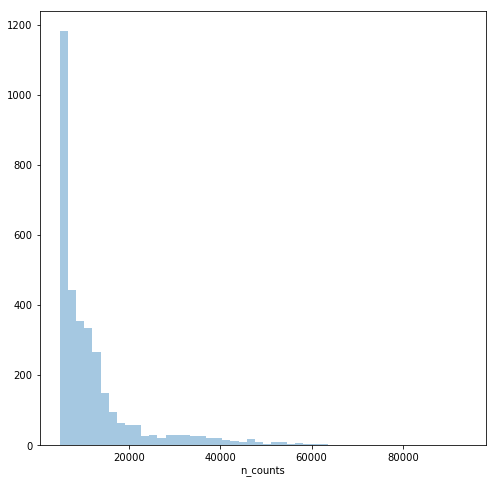

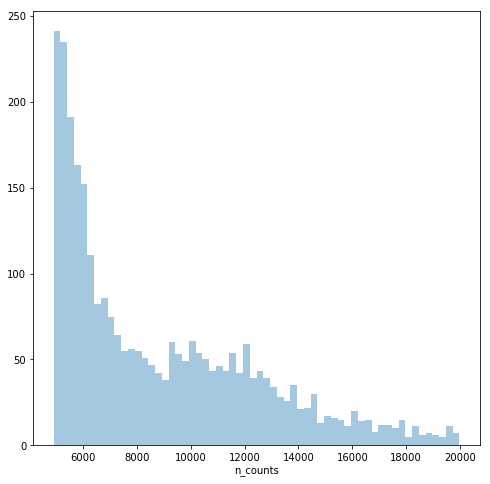

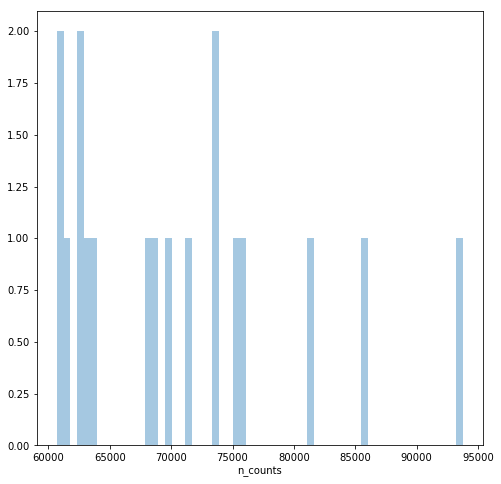

In [17]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>60000], kde=False, bins=60)
plt.show()

In [18]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 80000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 3383
filtered out 3 cells that havemore than 80000 counts
Number of cells after max count filter: 3380
Number of cells after MT filter: 3379


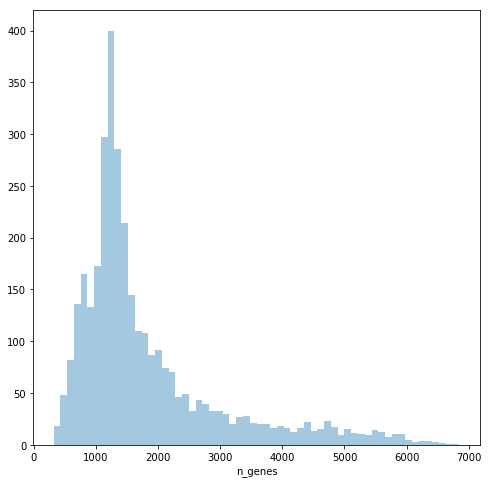

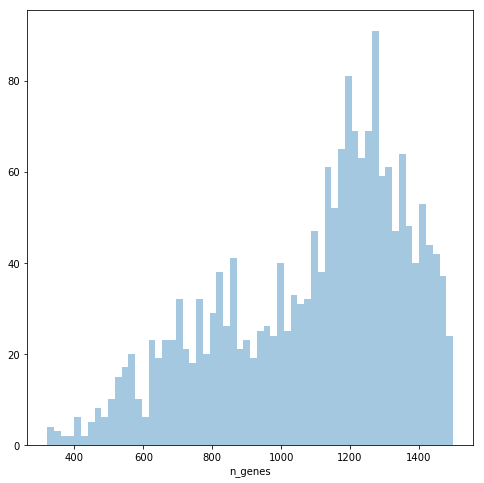

In [19]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 600 which should be filtered out.

In [20]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 600)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 3379
filtered out 114 cells that haveless than 600 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 3265


In [21]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 20529 genes that are detectedin less than 20 cells
Number of genes after cell filter: 13165


## 1.2 Normalization

In [22]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [23]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     646
1     381
2     358
3     353
4     331
5     282
6     264
7     239
8     232
9      62
10     44
11     37
12     36
Name: groups, dtype: int64

In [24]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [25]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [26]:
#Delete adata_pp
del adata_pp

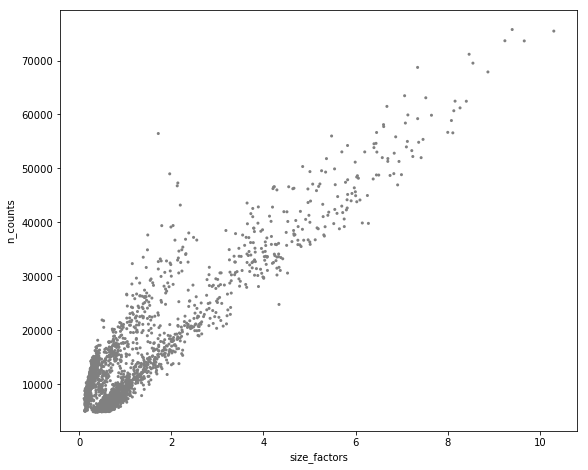

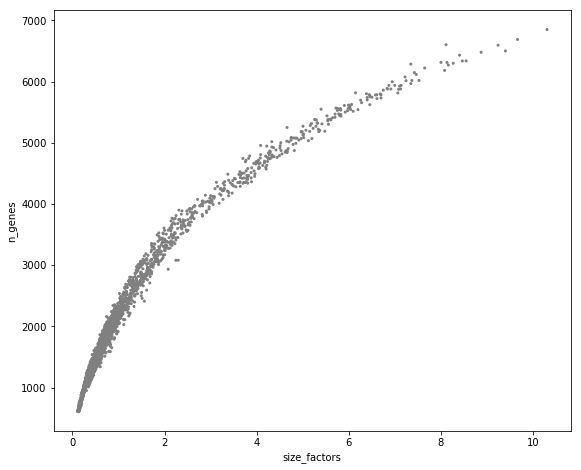

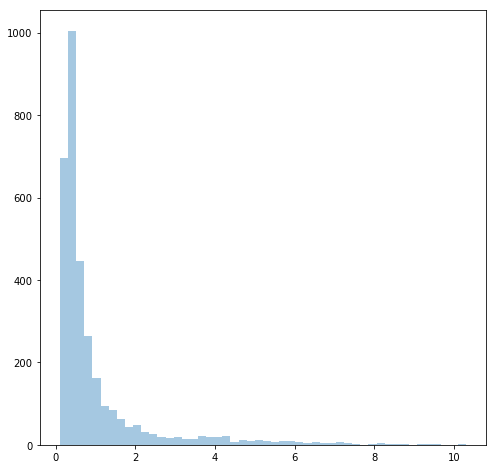

In [27]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [28]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [29]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [30]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [31]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


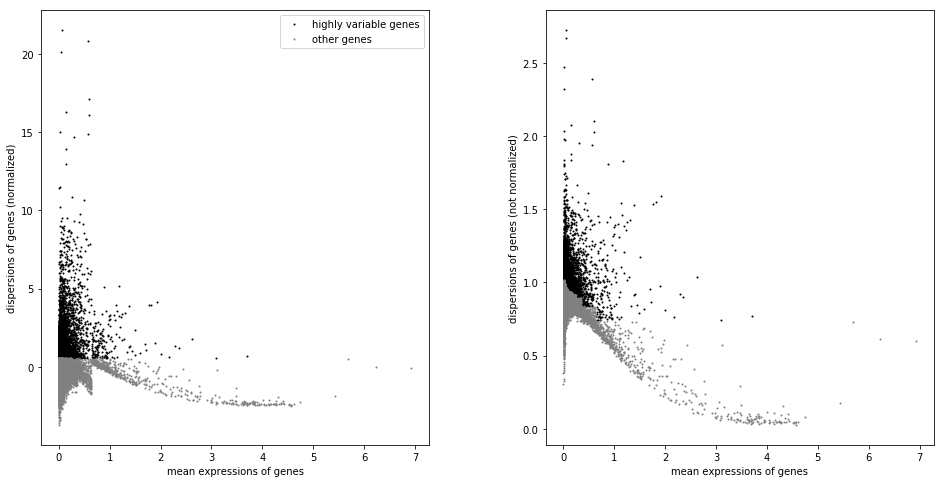

In [32]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [33]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9988843  0.9973397  0.99592507 0.99547684 0.99277616
     0.9874903  0.9845058  0.98251086 0.9789162  0.9758913  0.97486
     0.9725268  0.9645044  0.96265996]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:30)


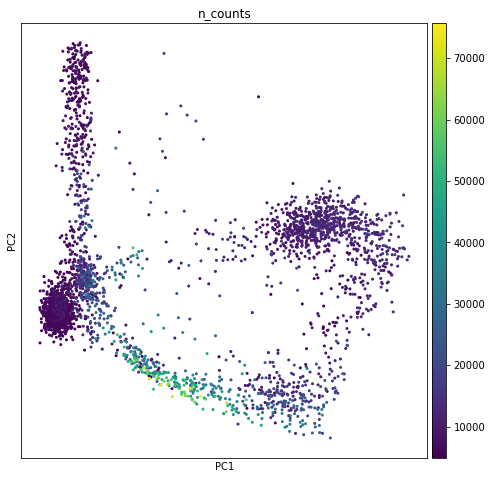

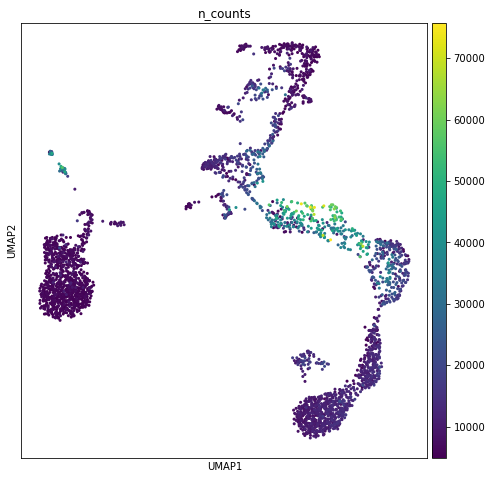

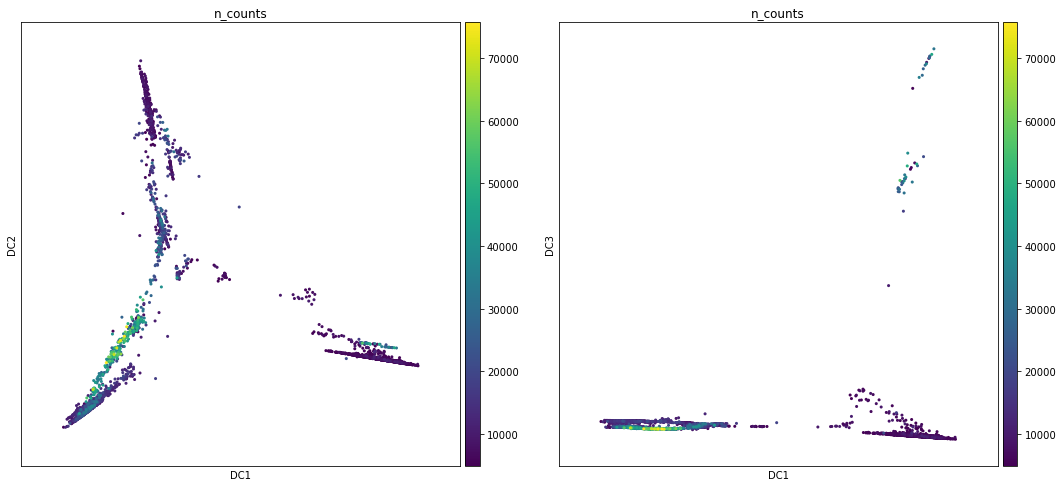

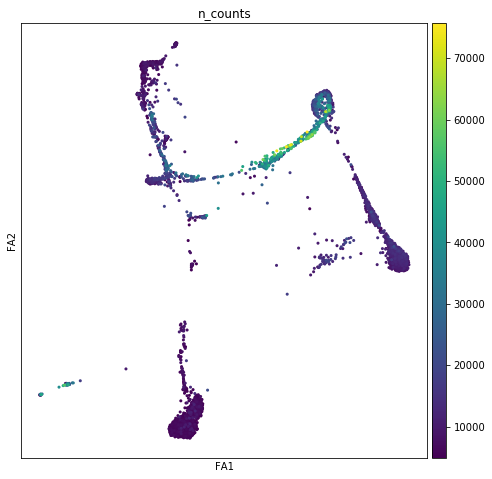

In [34]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [35]:
adata.write(results_file)

# 3. Clustering

In [36]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [37]:
adata.obs['louvain_r1'].value_counts()

0     639
1     589
2     299
3     295
4     291
5     276
6     263
7     249
8     101
9      93
10     63
11     41
12     40
13     26
Name: louvain_r1, dtype: int64

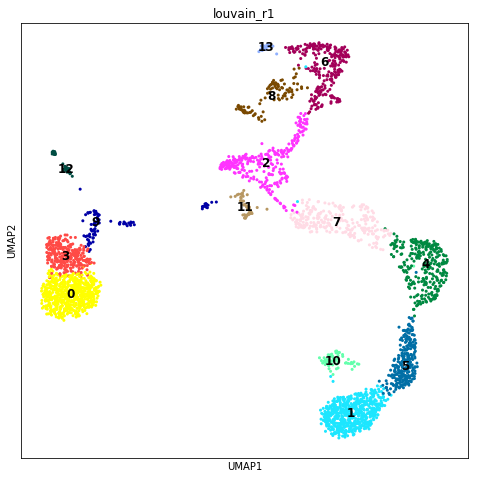

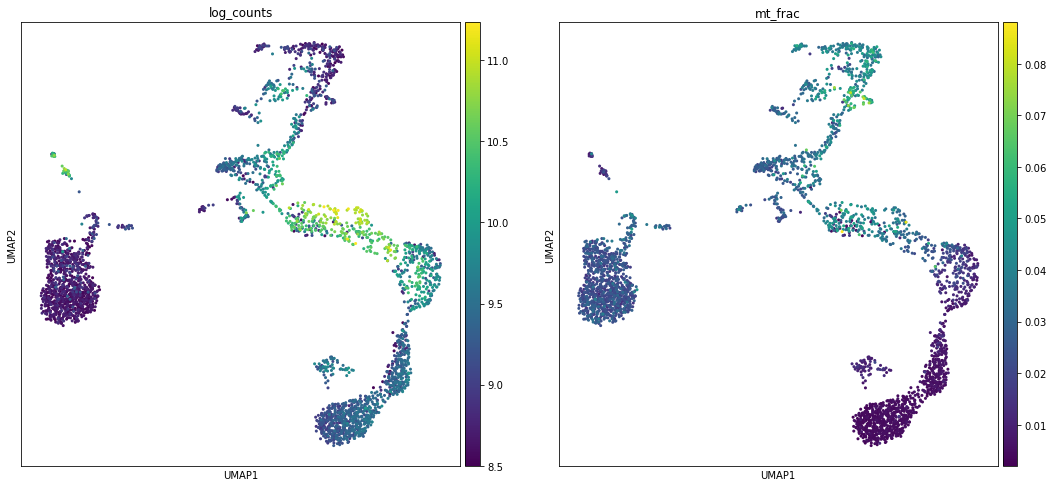

In [38]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 1)

In [39]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [40]:
markers_df = pd.read_csv('../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [41]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [42]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [43]:
# Select only human markers
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [44]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [45]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [46]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

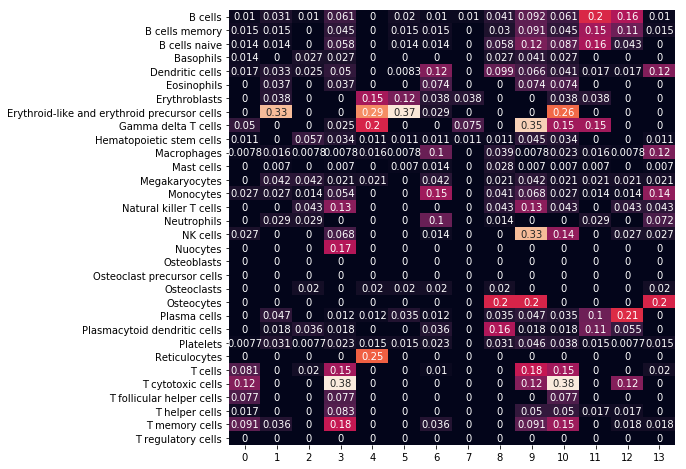

In [47]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

# 5. Plot makers of subtypes

In [48]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

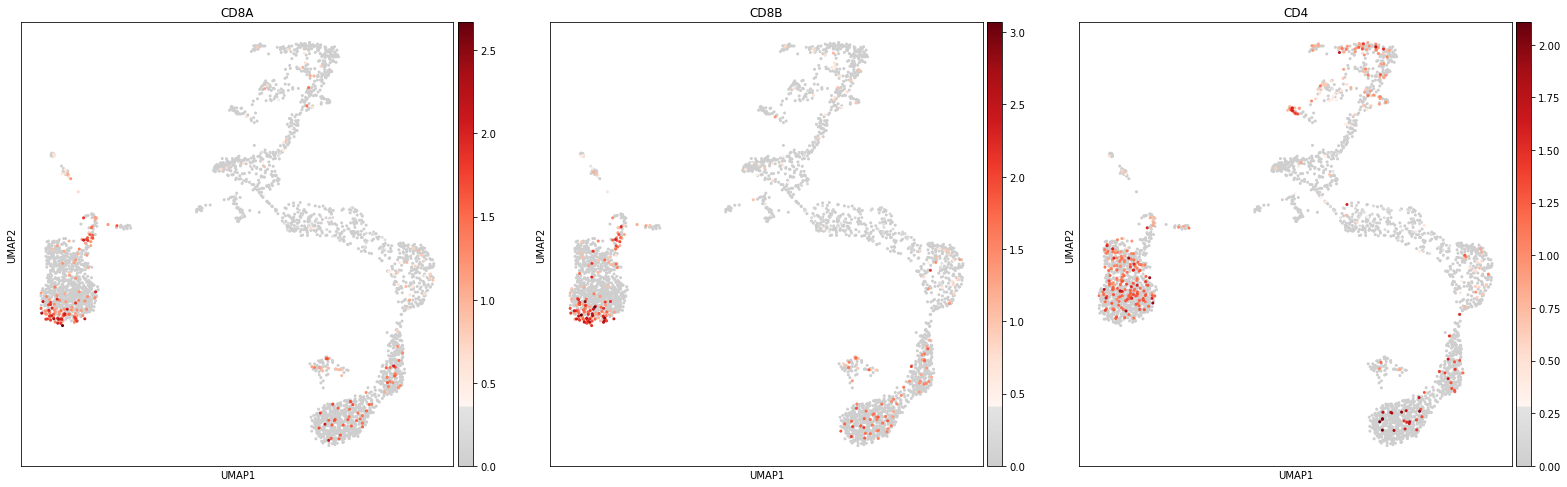

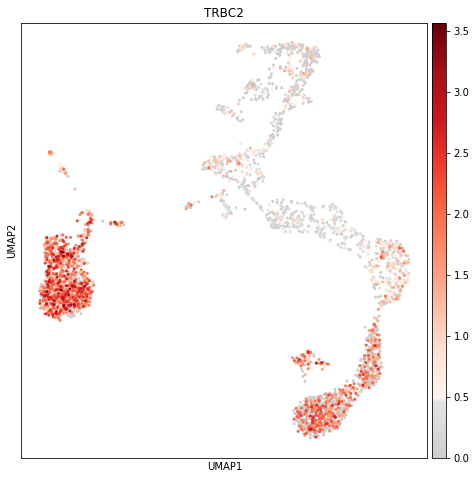

In [49]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap)

# Markers from MCA
sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap)

We need to subcluster cluster 0 to annotate CD4+ vs CD8+ cells. 

## NK cells

We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

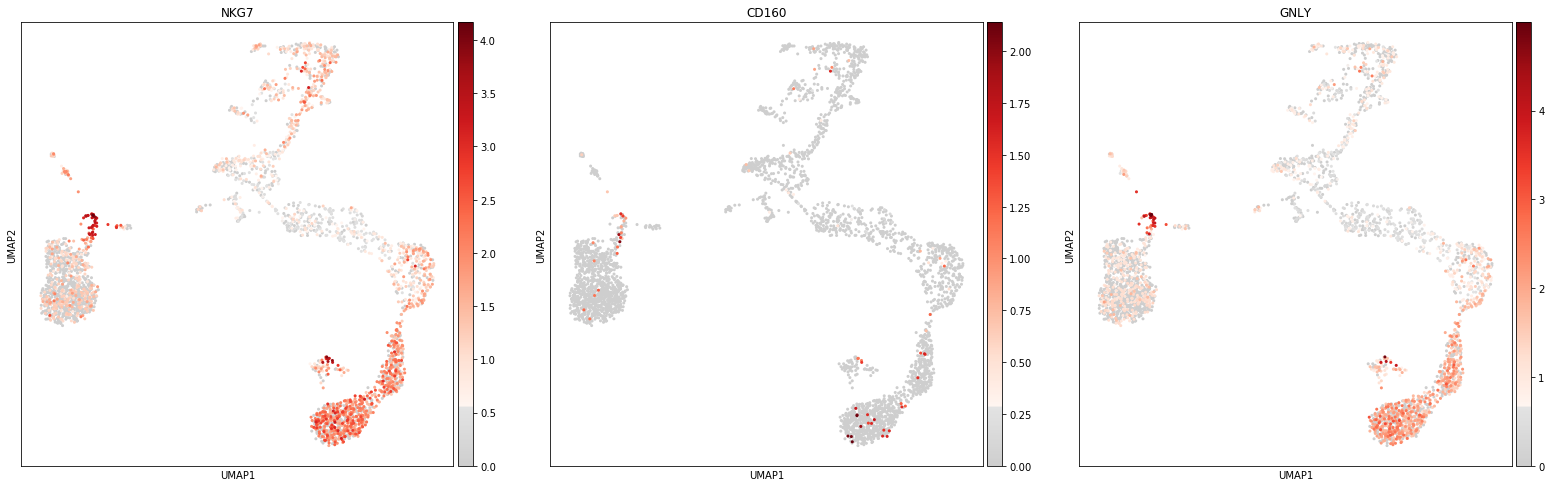

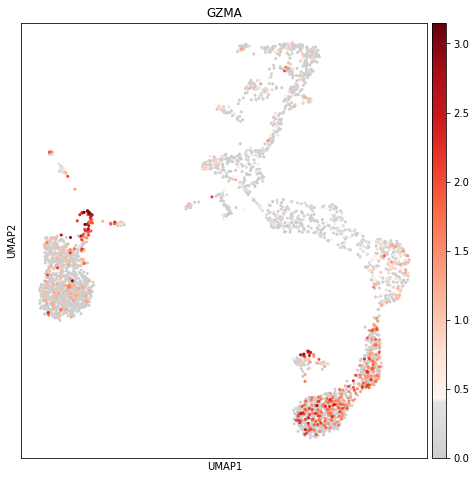

In [50]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

Cluster 12 is NK cells, cluster 9 is NKT cells.

## Monocytes: CD14+ and CD16+

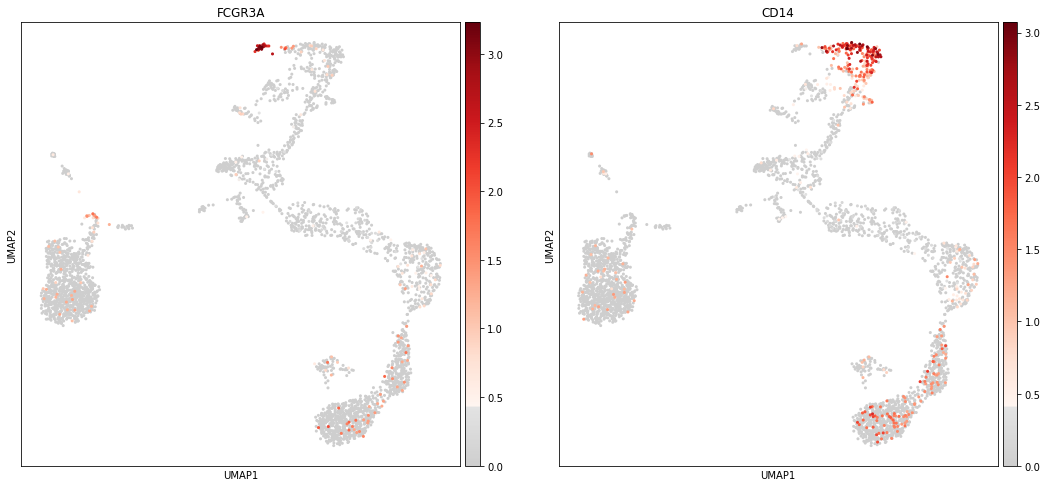

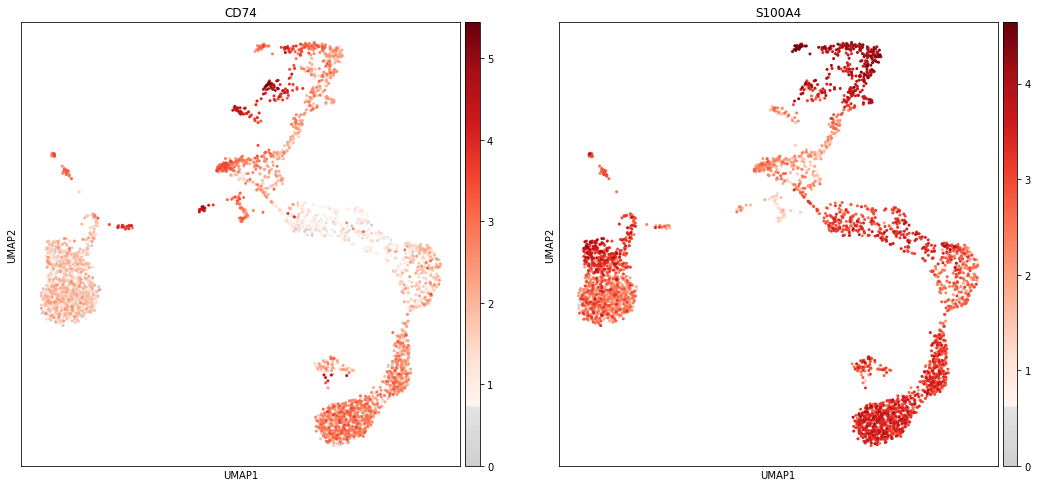

In [51]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['CD74', 'S100A4'], use_raw=False, color_map=mymap)

Cluster 13 is CD16+, cluster 6 is CD14+. 

## Monocytes progenitors

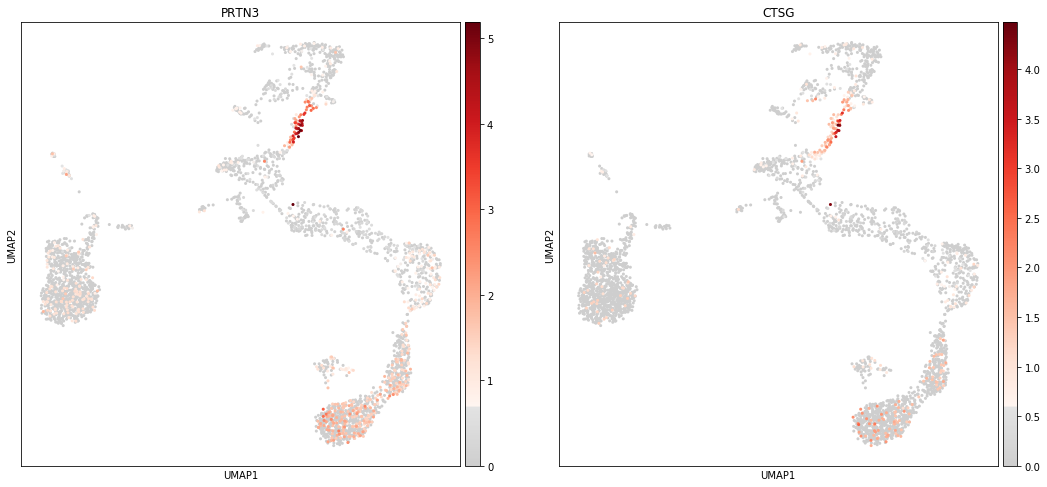

In [52]:
# Markers from MCA
sc.pl.umap(adata, color=['PRTN3','CTSG'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

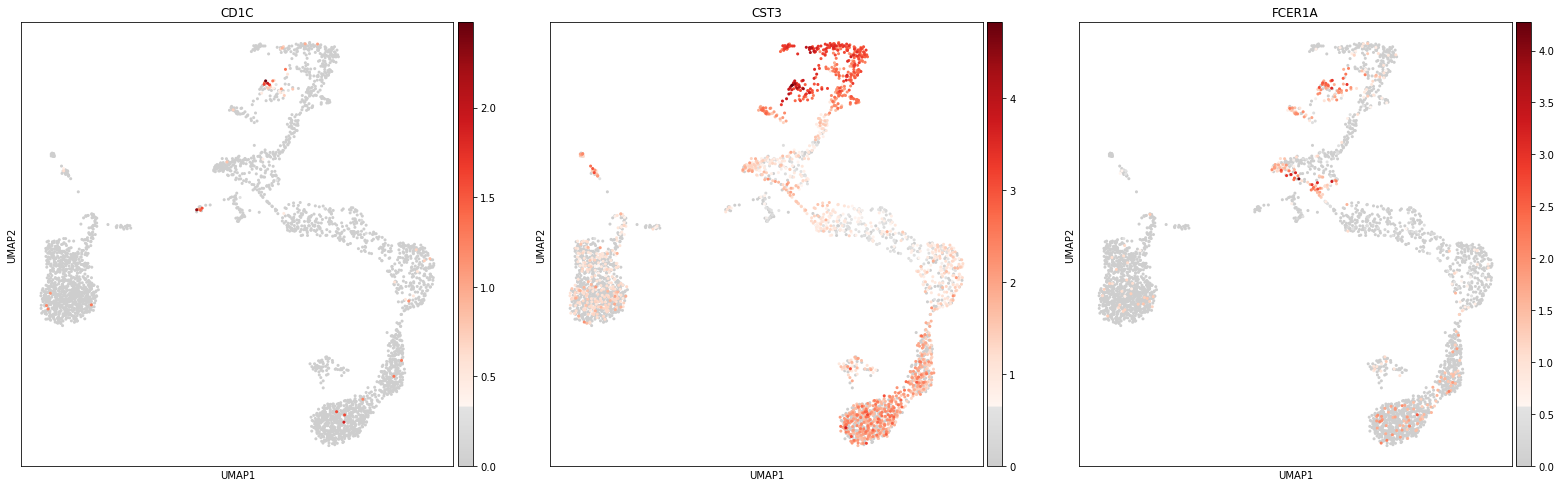

In [53]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

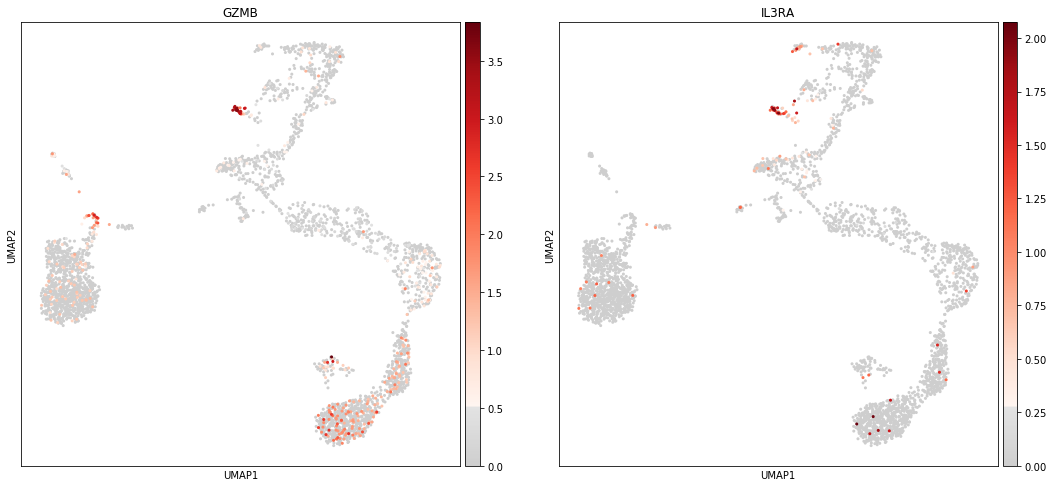

In [54]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

## B cells

Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).


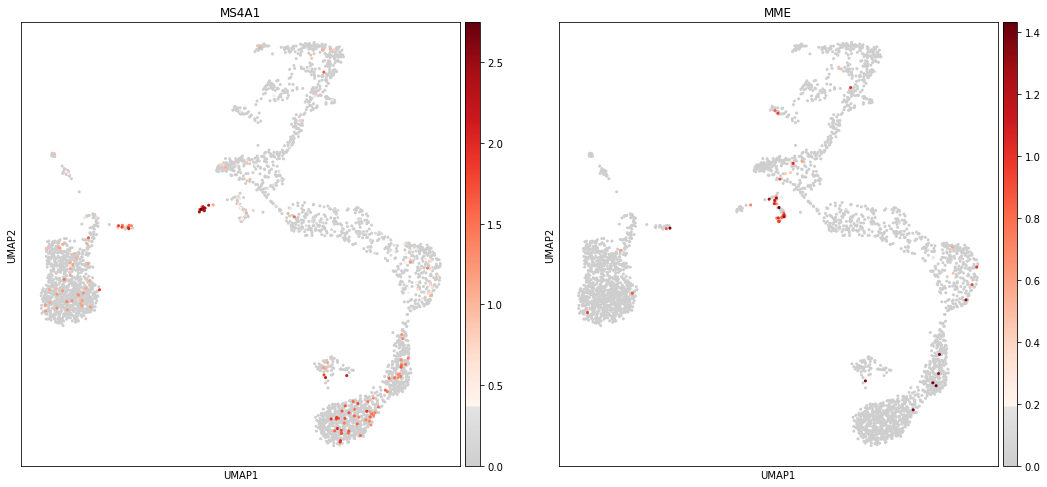

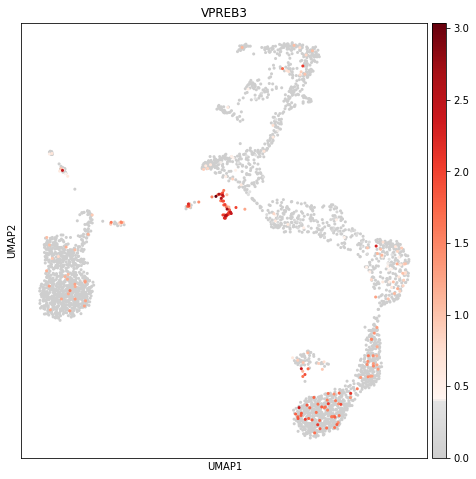

In [60]:
# Oetjen
sc.pl.umap(adata, color=['MS4A1', 'MME'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3'], use_raw=False, color_map=mymap)

## Hematopoietic stem progenitors cells (HSPCs)

Using markers from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?quickSearchInfo=bone%20marrow)

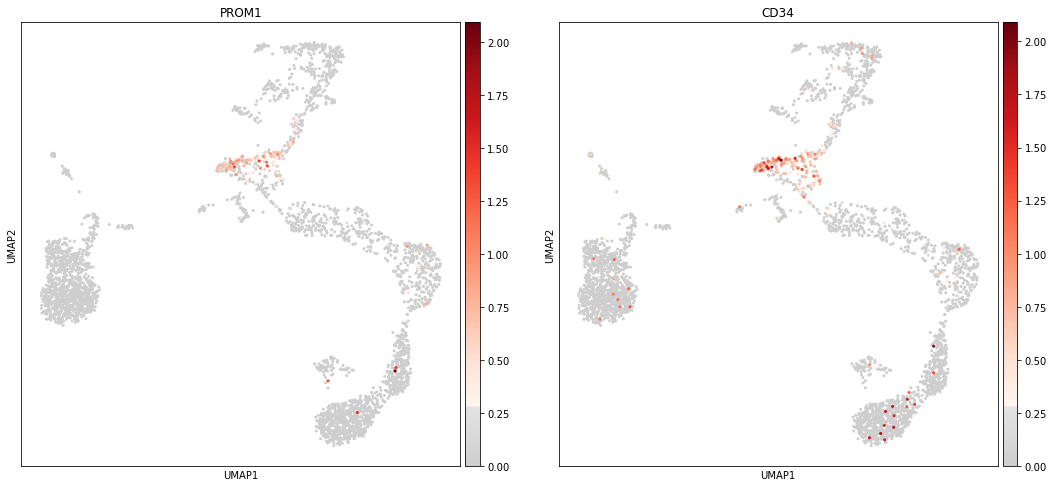

In [56]:
sc.pl.umap(adata, color=['PROM1', 'CD34'], use_raw=False, color_map=mymap)



## Megakaryocyte progenitors

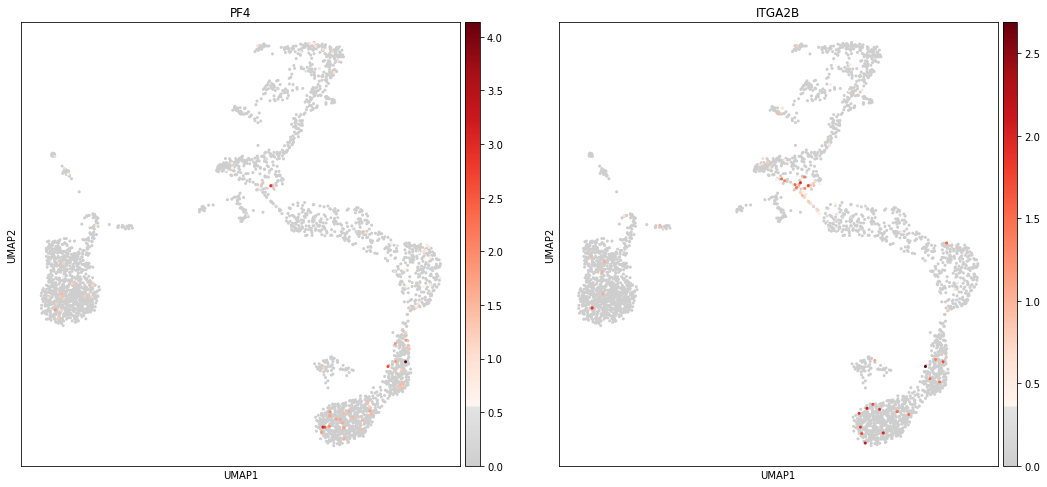

In [57]:
# Markers from Dahlin
sc.pl.umap(adata, color=['PF4', 'ITGA2B'], use_raw=False, color_map=mymap)

## Erythrocytes

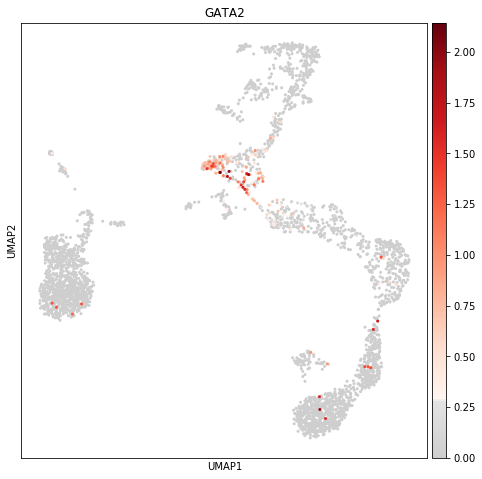

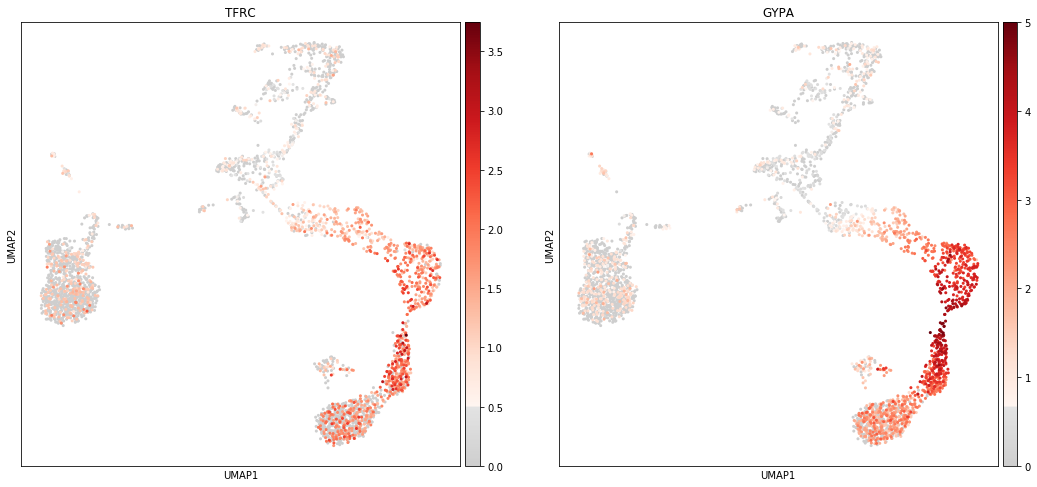

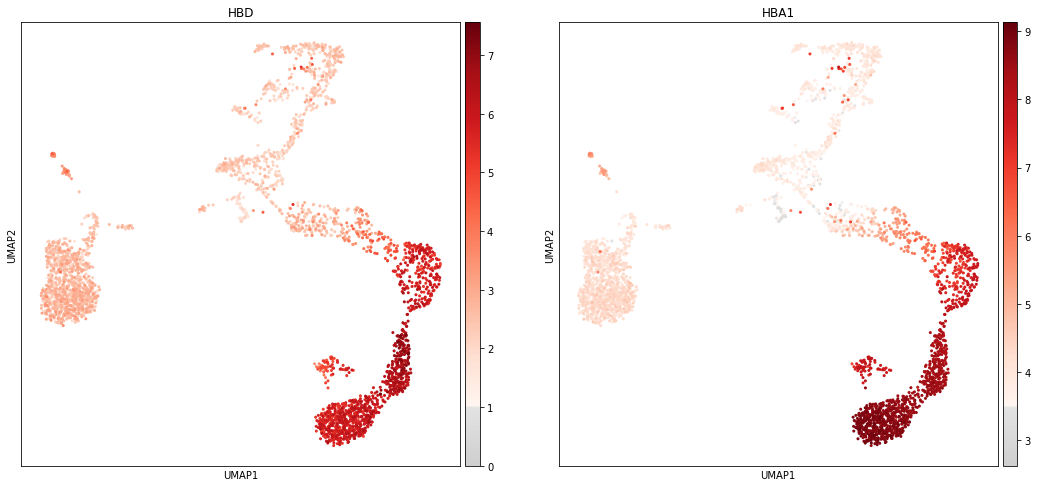

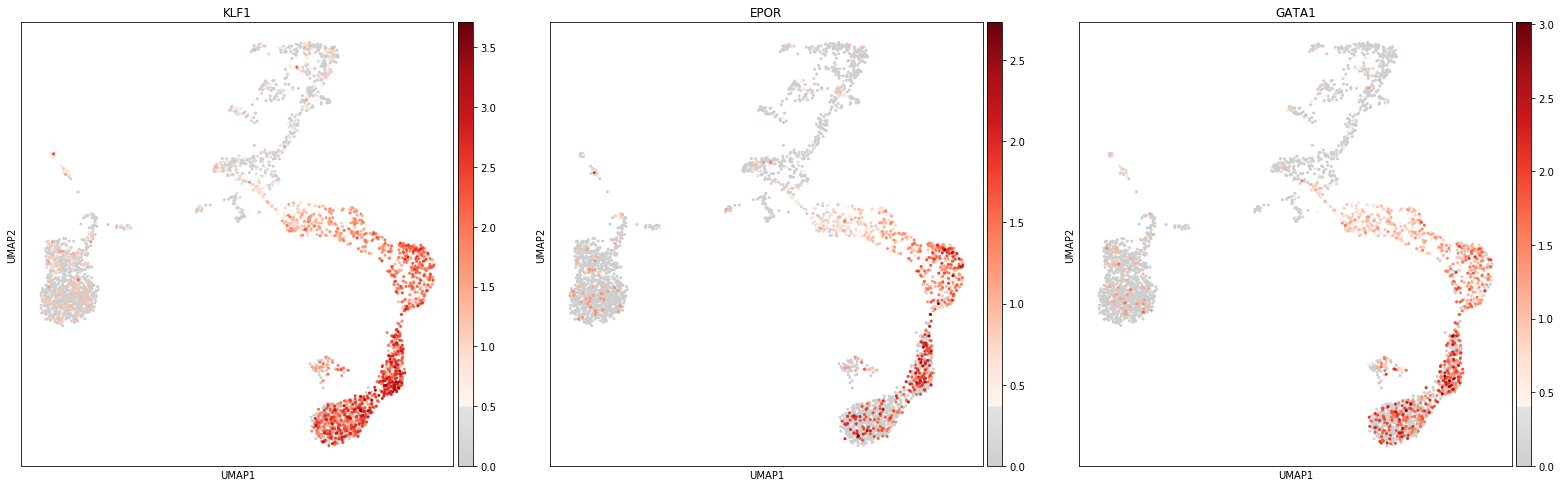

In [58]:
# Erythrocytes progenitors
sc.pl.umap(adata, color=['GATA2'], use_raw=False, color_map=mymap)

# markers from CellMarker (differentiated)
sc.pl.umap(adata, color=['TFRC', 'GYPA'], use_raw=False, color_map=mymap)

# markers from Oetjen and MCA (differentiated)
sc.pl.umap(adata, color=['HBD', 'HBA1'], use_raw=False, color_map=mymap)

# markers from Dahlin
sc.pl.umap(adata, color=['KLF1', 'EPOR', 'GATA1'], use_raw=False, color_map=mymap)

## Plasma cells

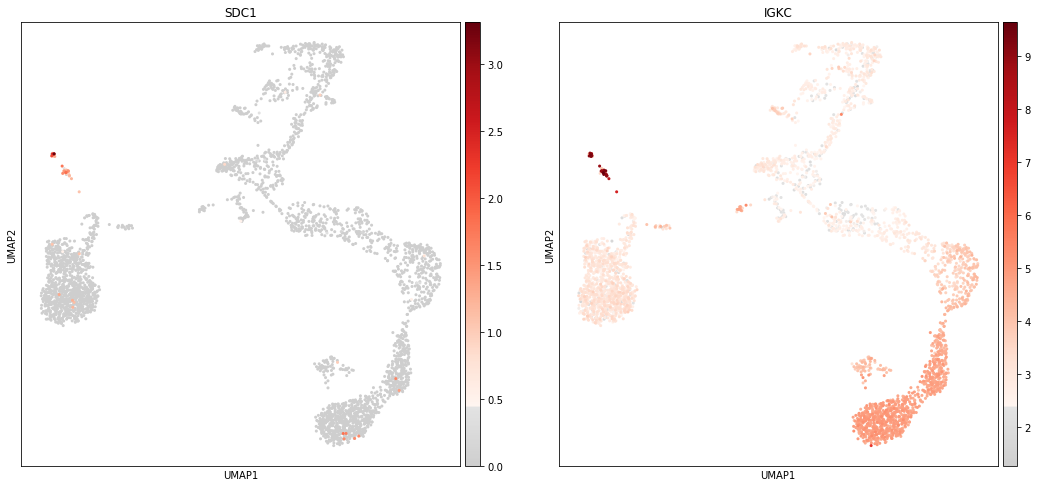

In [61]:
# From CellMarker
sc.pl.umap(adata, color=['SDC1', 'IGKC'], use_raw=False, color_map=mymap)

# 6. Subclustering

In [81]:
#Subcluster cluster9
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['9']), resolution=0.3, key_added='louvain_r1_sub9')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r1_sub9', the cluster labels (adata.obs, categorical) (0:00:00)


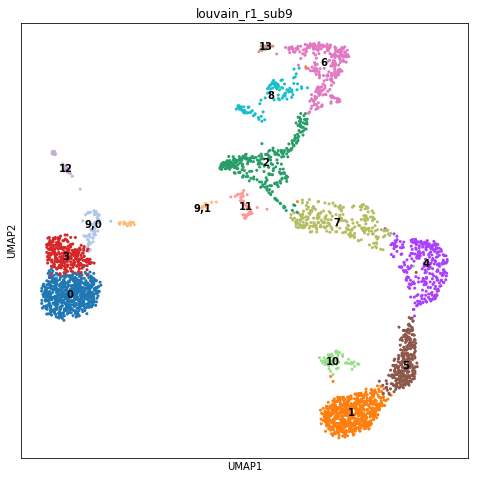

In [82]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub9', legend_loc='on data')

In [83]:
#Subcluster cluster8
sc.tl.louvain(adata, restrict_to=('louvain_r1_sub9', ['8']), resolution=0.3, key_added='louvain_r1_sub9_8')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_r1_sub9_8', the cluster labels (adata.obs, categorical) (0:00:00)


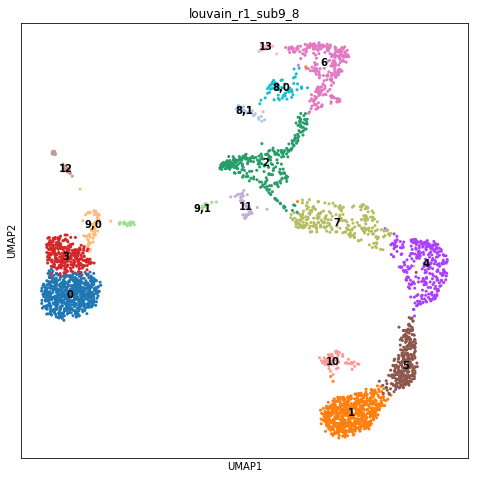

In [84]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub9_8', legend_loc='on data')

In [85]:
#Subcluster cluster2
sc.tl.louvain(adata, restrict_to=('louvain_r1_sub9_8', ['2']), resolution=0.3, key_added='louvain_r1_sub9_8_2')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_r1_sub9_8_2', the cluster labels (adata.obs, categorical) (0:00:00)


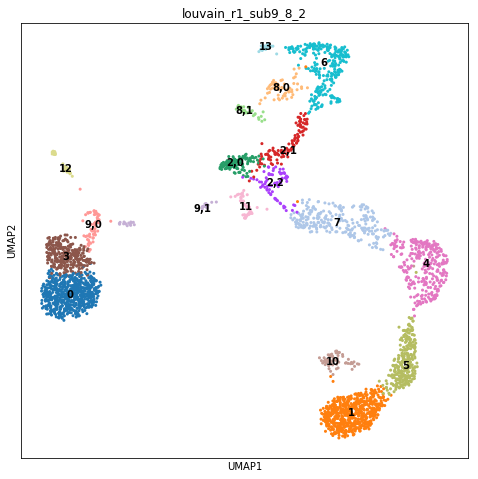

In [86]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub9_8_2', legend_loc='on data')

# 7. Final cell-type annotation

In [5]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1_sub9_8_2']
adata.rename_categories('final_annotation', ['CD8+ T cells', 'Erythrocytes,1', 'HSPCs', 'Monocyte progenitors', 'Megakaryocyte progenitors', 'CD4+ T cells', 'Erythrocytes,2', 'Erythrocytes,3', 'CD14+ Monocytes', 'Erythroid progenitors','Monocyte-derived dendritic cells','Plasmacytoid dendritic cells', 'NKT cells', 'CD20+ B cells','Erythrocytes,4', 'CD10+ B cells', 'Plasma cells', 'CD16+ Monocytes'])

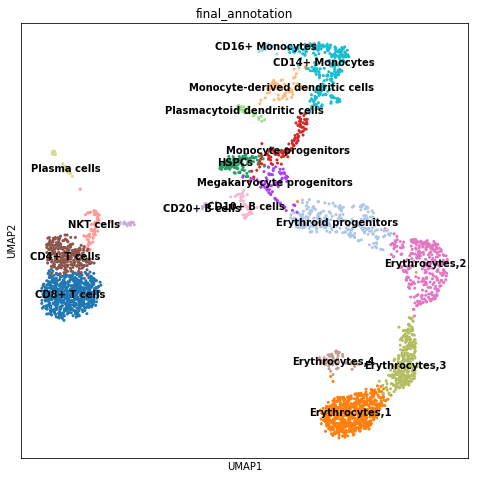

In [6]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [7]:
tmp = adata.obs['final_annotation']
tmp = ['Erythrocytes' if item.startswith('Erythrocytes') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


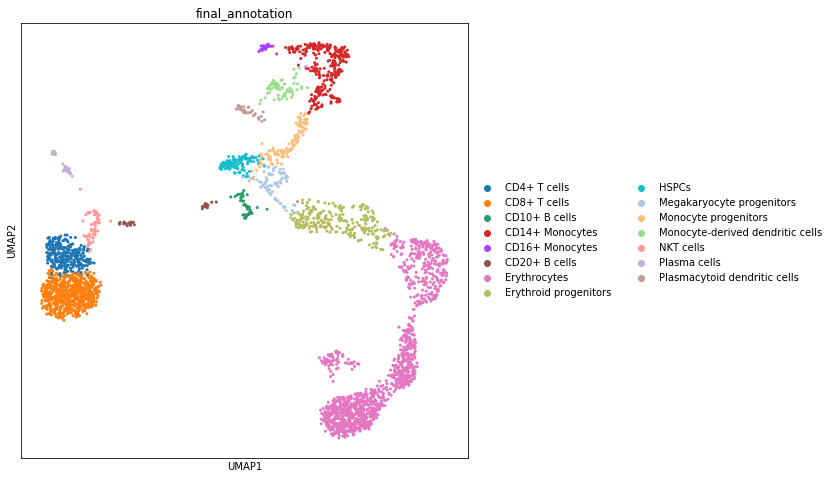

In [8]:
sc.pl.umap(adata, color='final_annotation')

In [9]:
# save final result
adata.write(results_file)

# Erythrocyte differentiation
Here we want to investigate the trajectory of erythrocytes differentiation using PAGA and DPT.

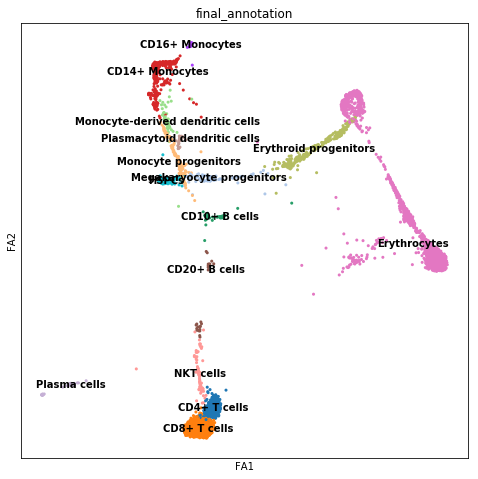

In [10]:
sc.pl.draw_graph(adata, color='final_annotation', legend_loc='on data')

In [11]:
sc.tl.paga(adata, groups='final_annotation')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


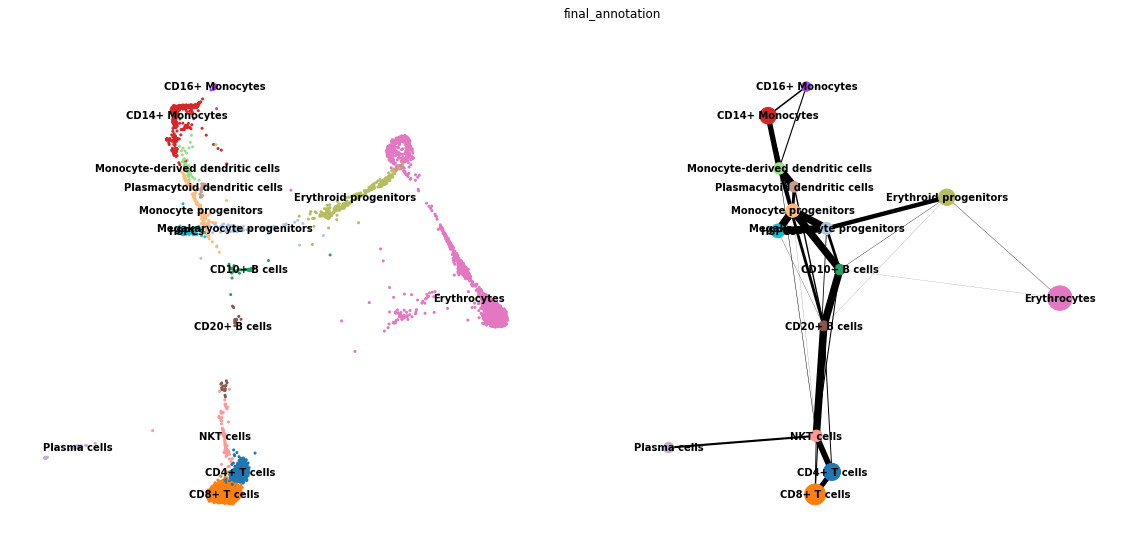

In [12]:
sc.pl.paga_compare(adata, color='final_annotation')

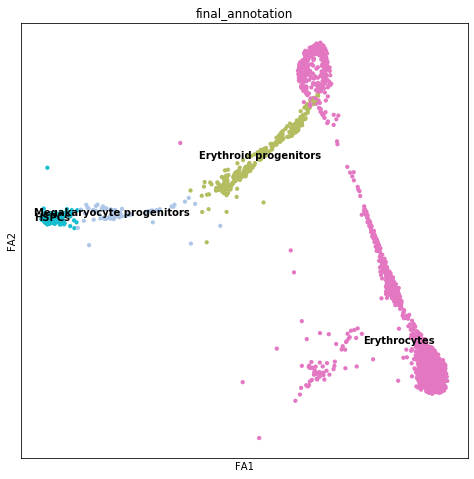

In [6]:
# Subsetting adata to only the clusters included in the trajectory
adata_ery = adata[adata.obs['final_annotation'].isin(['HSPCs', 'Megakaryocyte progenitors', 'Erythroid progenitors', 'Erythrocytes'])]
sc.pl.draw_graph(adata_ery, color='final_annotation', legend_loc='on data')

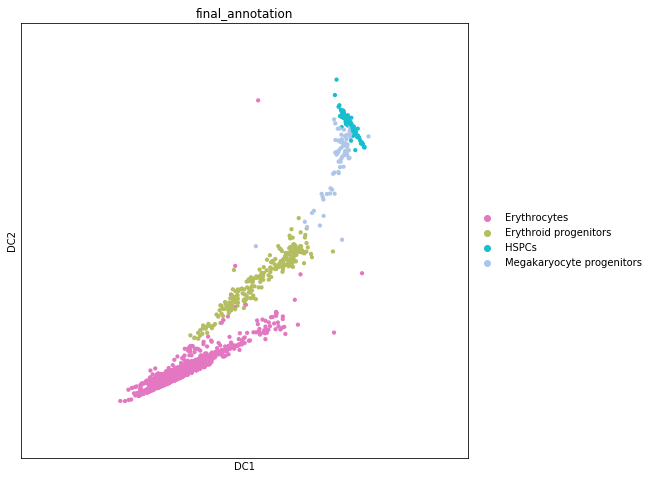

In [7]:
sc.pl.diffmap(adata_ery, components='1,2', color='final_annotation')

In DPT we must assign a root cell to infer pseudotime. We do so by looking at the diffmap plots and choosing the root cell as the one with the maximum DC2 value.

In [8]:
# Calculate pseudotime with DPT
root_mask = adata_ery.obs.final_annotation.isin(['HSPCs'])
max_root_id = np.argmax(adata_ery.obsm['X_diffmap'][root_mask,2])
root_id = np.arange(len(root_mask))[root_mask][max_root_id]
adata_ery.uns['iroot'] = root_id

sc.tl.dpt(adata_ery, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


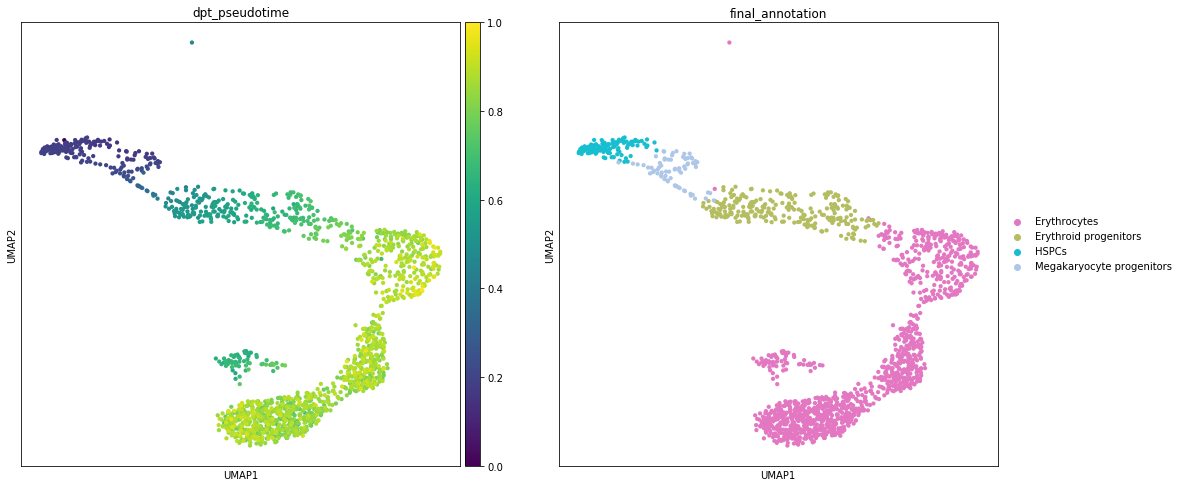

In [9]:
sc.pl.umap(adata_ery, color=['dpt_pseudotime', 'final_annotation'])

In [10]:
# Save ordering of cells in the original adata object

# save adata_ery.obs as a dataframe and make barcodes column accessible
adata_ery_df = adata_ery.obs.reset_index()
adata_ery_df.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAACGGGAGCTCCTCT-1   12687.0    9.448333     1025  0.003232      0.271026   
1  AAACGGGCAGACAAAT-1   12977.0    9.470934     1198  0.004084      0.345565   
2  AAACGGGGTATATGGA-1   17855.0    9.790039     3453  0.035564      2.289581   
3  AAAGATGAGCTAGTTC-1   22818.0   10.035305     3320  0.027697      1.719387   
4  AAAGATGCAGTATAAG-1   11649.0    9.362976      959  0.004721      0.240723   

  louvain_r1 louvain_r1_sub0 louvain_r1_sub9 louvain_r1_sub9_8  \
0          1               1               1                 1   
1          5               5               5                 5   
2          2               2               2                 2   
3          4               4               4                 4   
4          1               1               1                 1   

  louvain_r1_sub9_8_2           final_annotation  dpt_pseudotime  
0                   1               Erythrocytes        0.902288  
1                   5               Erythrocytes        0.919230  
2                 2,2  Megakaryocyte progenitors        0.209312  
3                   4               Erythrocytes        0.799489  
4                   1               Erythrocytes        0.912797

In [11]:
# prepare adata_ery_df for merging
adata_ery_df = adata_ery_df[['barcode', 'dpt_pseudotime']]
adata_ery_df.head()

barcode  dpt_pseudotime
0  AAACGGGAGCTCCTCT-1        0.902288
1  AAACGGGCAGACAAAT-1        0.919230
2  AAACGGGGTATATGGA-1        0.209312
3  AAAGATGAGCTAGTTC-1        0.799489
4  AAAGATGCAGTATAAG-1        0.912797

In [12]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAACCTGAGAGAGCTC-1    5535.0    8.618847     1362  0.024029      0.431830   
1  AAACCTGAGGCAAAGA-1    6105.0    8.716864     1286  0.017527      0.443113   
2  AAACCTGCACGAGGTA-1    6150.0    8.724207     1502  0.024065      0.615241   
3  AAACCTGGTCCGAATT-1    4978.0    8.512783     1190  0.018280      0.409031   
4  AAACCTGTCCTAAGTG-1    5206.0    8.557567     1355  0.034960      0.481356   

  louvain_r1 louvain_r1_sub0 louvain_r1_sub9 louvain_r1_sub9_8  \
0          0             0,3               0                 0   
1          3               3               3                 3   
2          3               3               3                 3   
3          0             0,1               0                 0   
4          3               3               3                 3   

  louvain_r1_sub9_8_2 final_annotation  dpt_pseudotime  
0                   0     CD8+ T cells             NaN  
1                   3     CD4+ T cells             NaN  
2                   3     CD4+ T cells             NaN  
3                   0     CD8+ T cells             NaN  
4                   3     CD4+ T cells             NaN

In [13]:
# merge the two dataframes
adata_merge = adata_df.merge(adata_ery_df, how='left', on='barcode')
adata_merge.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAACCTGAGAGAGCTC-1    5535.0    8.618847     1362  0.024029      0.431830   
1  AAACCTGAGGCAAAGA-1    6105.0    8.716864     1286  0.017527      0.443113   
2  AAACCTGCACGAGGTA-1    6150.0    8.724207     1502  0.024065      0.615241   
3  AAACCTGGTCCGAATT-1    4978.0    8.512783     1190  0.018280      0.409031   
4  AAACCTGTCCTAAGTG-1    5206.0    8.557567     1355  0.034960      0.481356   

  louvain_r1 louvain_r1_sub0 louvain_r1_sub9 louvain_r1_sub9_8  \
0          0             0,3               0                 0   
1          3               3               3                 3   
2          3               3               3                 3   
3          0             0,1               0                 0   
4          3               3               3                 3   

  louvain_r1_sub9_8_2 final_annotation  dpt_pseudotime_x  dpt_pseudotime_y  
0                   0     CD8+ T cells               NaN               NaN  
1                   3     CD4+ T cells               NaN               NaN  
2                   3     CD4+ T cells               NaN               NaN  
3                   0     CD8+ T cells               NaN               NaN  
4                   3     CD4+ T cells               NaN               NaN

In [14]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

In [15]:
# save final result
adata.write(results_file)